In [21]:
import numpy as np
import matplotlib.pyplot as plt
import libstempo as T
import libstempo.plot as LP, libstempo.toasim as LT
import glob
import math
import json
from enterprise.signals import gp_signals
from enterprise_extensions import model_utils, blocks
import dynesty
from enterprise.signals import signal_base
from enterprise.pulsar import Pulsar
from enterprise_extensions.frequentist import optimal_statistic as opt_stat
import enterprise.signals.parameter as parameter
from enterprise.signals import white_signals
from enterprise_extensions.blocks import white_noise_block, red_noise_block, dm_noise_block
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import corner

In [2]:
parfiles= sorted(glob.glob('/data/' + 'test_3.par'))
timfiles = sorted(glob.glob('/data/'+ 'combined_dm_red.tim'))

psrs = []
ephemeris = None
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem=ephemeris)
    psrs.append(psr)

In [3]:
# find the maximum time span to set GW frequency sampling
Tspan = model_utils.get_tspan(psrs)

# Here we build the signal model
# First we add the timing model
s = gp_signals.TimingModel()

# Then we add the white noise
# We use different white noise parameters for every backend/receiver combination
# The white noise parameters are held constant
efac = parameter.Constant(1.0)
s += white_signals.MeasurementNoise(efac=efac)

# Finally, we add the common red noise, which is modeled as a Fourier series with 30 frequency components
# The common red noise has a power-law PSD with spectral index of 4.33
s += blocks.common_red_noise_block(psd='powerlaw', prior='log-uniform', Tspan=Tspan,
                                   components=30, name='red_noise', orf = None)
s += dm_noise_block(components=30) 

# We set up the PTA object using the signal we defined above and the pulsars
pta = signal_base.PTA([s(p) for p in psrs])

In [4]:
pta.params

[fake_test_3_dm_gp_gamma:Uniform(pmin=0, pmax=7),
 fake_test_3_dm_gp_log10_A:Uniform(pmin=-20, pmax=-11),
 red_noise_gamma:Uniform(pmin=0, pmax=7),
 red_noise_log10_A:Uniform(pmin=-18, pmax=-11)]

In [5]:
#%% Nested Sampling with dynesty

def TransformPrior(theta, verbose=False):
	if verbose:
		print('\n', len(theta), '\n')
	ph_pars = np.zeros(len(theta))
	idx_offset = 0
	for i, nm in enumerate(pta.params):
		if nm.size and nm.size>1:
			for j in range(nm.size):
				ph_pars[i+idx_offset] = (pta.params[i].prior.func_kwargs['pmax'] - pta.params[i].prior.func_kwargs['pmin']) * theta[i+idx_offset] + pta.params[i].prior.func_kwargs['pmin']
				idx_offset+=1
		else:
			ph_pars[i+idx_offset] = ( pta.params[i].prior.func_kwargs['pmax'] - pta.params[i].prior.func_kwargs['pmin'])*theta[i+idx_offset] + pta.params[i].prior.func_kwargs['pmin']
		if verbose:
			print(nm, pta.params[i].prior.func_args, pta.params[i].prior.func_kwargs['pmin'], pta.params[i].prior.func_kwargs['pmax'])
	return ph_pars

def log_l(x):
	return pta.get_lnlikelihood(x)

ndim = len(pta.params)
# initialize sampler with pool with pre-defined queue

Npar = len(pta.params)

sampler = dynesty.NestedSampler(log_l, TransformPrior, ndim=Npar, nlive=500, bound='multi', sample='rwalk')

sampler.run_nested(dlogz=0.1)

7684it [01:02, 123.48it/s, +500 | bound: 79 | nc: 1 | ncall: 160022 | eff(%):  5.130 | loglstar:   -inf < 11833.729 <    inf | logz: 11820.705 +/-  0.151 | dlogz:  0.000 >  0.100]


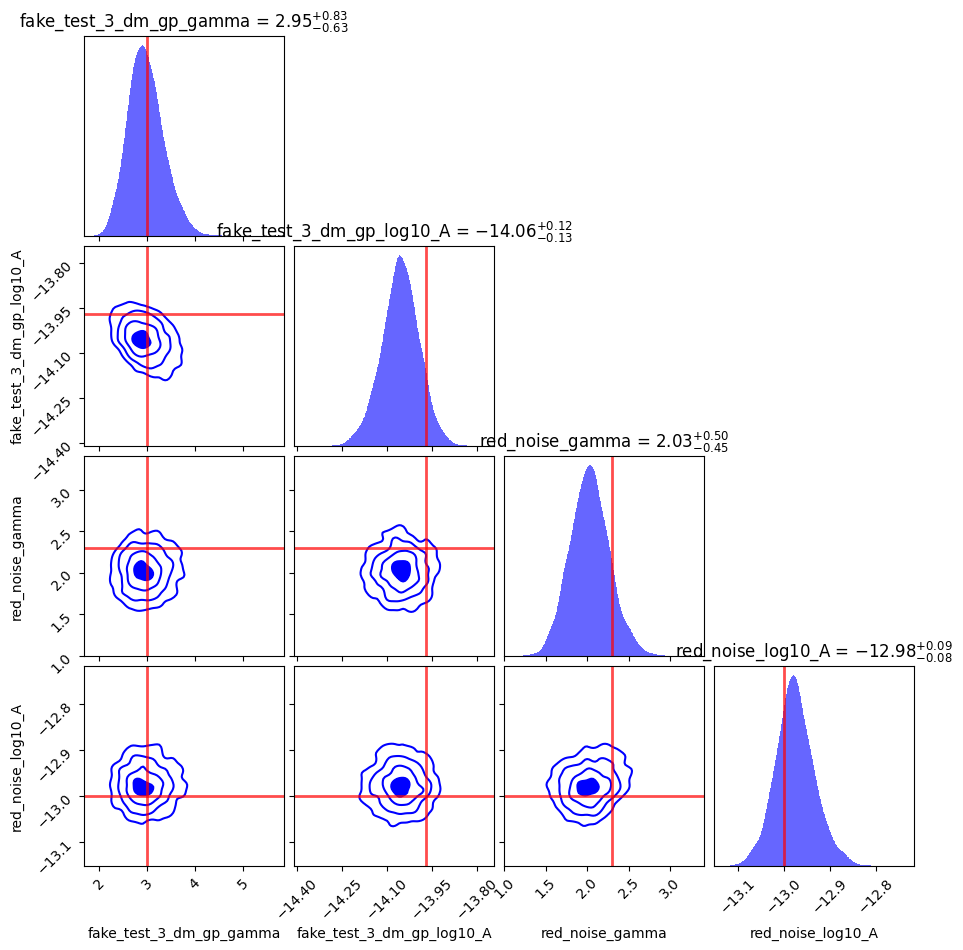

In [7]:
from dynesty import plotting as dyplot
results = sampler.results
fig, axes = dyplot.cornerplot(results,
                             show_titles=True, truths = [3, np.log10(5e-12)-2.67, 2.3, np.log10(1e-13)], labels=pta.param_names, color='blue',
                             quantiles=None)

In [15]:
xs = {par.name: par.sample() for par in pta.params}
print(xs)

{'fake_test_3_dm_gp_gamma': 2.089440520869438, 'fake_test_3_dm_gp_log10_A': -11.842892204970374, 'red_noise_gamma': 5.4244633903153066, 'red_noise_log10_A': -13.783210097859236}


In [16]:
# # dimension of parameter space
ndim = len(xs)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2) #Создаёт диагональную матрицу размерности ndim x ndim с элементами 0.0001задаёт начальный размер "шага" сэмплера по каждому параметру 

# # set up jump groups by red noise groups
ndim = len(xs)
groups  = [range(0, ndim)]#создаёт группу из всех параметров
groups.extend([[0,1]])#добавляет отдельную группу для параметров с индексами 1 и 2, Ускоряет сходимость, обновляя коррелированные параметры (например, амплитуду и спектральный индекс) совместно.
# intialize sampler
sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, groups=groups, outDir='/data')

In [17]:
N = 100000 #общее количество итераций MCMC
x0 = np.hstack(p.sample() for p in pta.params) 
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 0.00 percent in 0.027442 s Acceptance rate = 0

/tmp/ipykernel_68082/1040468519.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Finished 1.00 percent in 0.539538 s Acceptance rate = 0.78

/usr/local/lib/python3.10/dist-packages/enterprise/signals/parameter.py:70: RuntimeWarning: divide by zero encountered in log


Adding DE jump with weight 5097260 s Acceptance rate = 0.17671
Finished 100.00 percent in 40.837366 s Acceptance rate = 0.30143
Run Complete


In [18]:
chain = np.loadtxt('/data/chain_1.txt') #загружаются данные цепочки MCMC из файла
pars = sorted(xs.keys())
burn = int(0.25 * chain.shape[0])#первые 25% шагов цепочки отбрасываются 

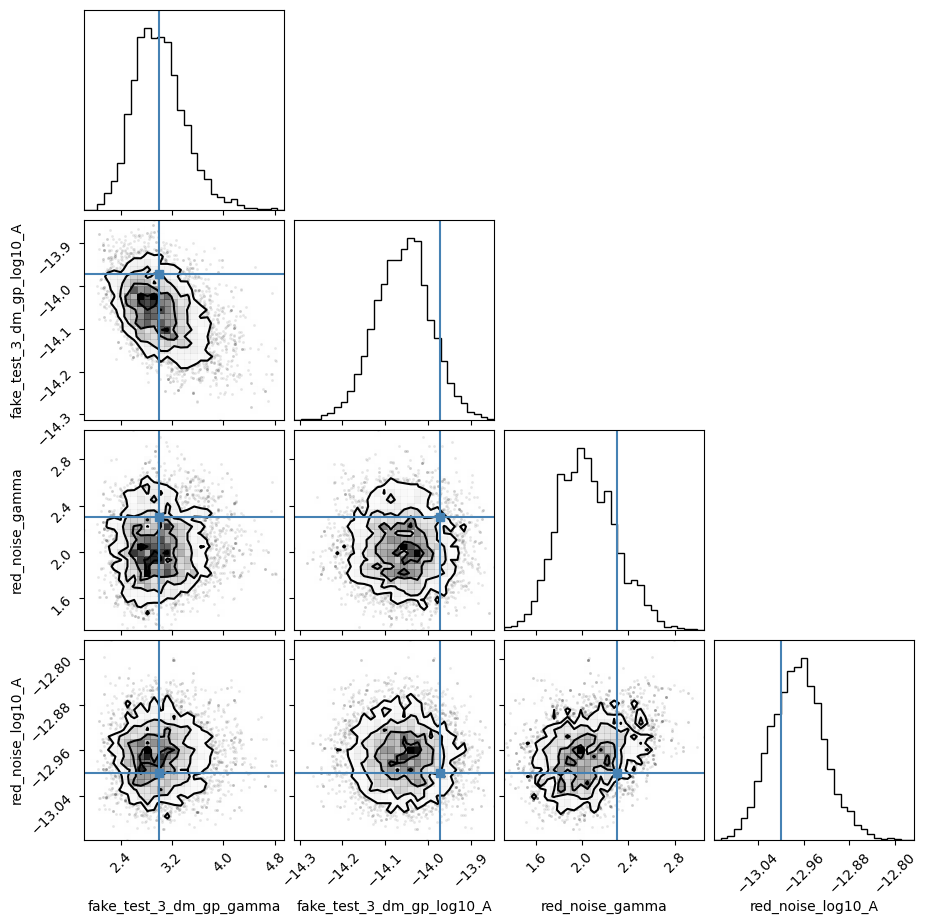

In [23]:
truths = [3, np.log10(5e-12)-2.67, 2.3, np.log10(1e-13)]#задаются эталонные значения параметров для сравнения с результатами MCMC.
corner.corner(chain[burn:,:-4], 30, truths=truths, labels=pars);